In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
from particles import resampling as rs
import sys
sys.path.append('..')

import Donut as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Donut/../utils.py'>

In [2]:
d = 2
ystar = 5
sigma = 0.25

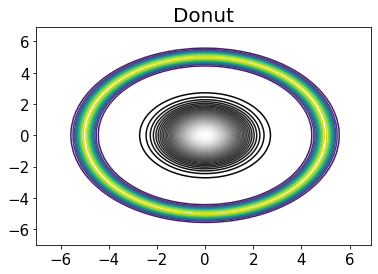

In [3]:
xx = np.arange(-7, 7, 0.1)
yy = np.arange(-7, 7, 0.1)
x, y = np.mgrid[-7:7:.1, -7:7:.1]
data = np.dstack((x, y))
z = np.exp(-0.5*(linalg.norm(data, axis = 2) - ystar)**2/(sigma**2))
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
plt.contour(x, y, z, 15)
plt.contour(x, y, zinitial, 15, cmap = 'gray', levels = 50)
plt.title('Donut', fontsize = 20)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig("donut.pdf")

## Algorithms

In [4]:
true_sample = 16*np.random.uniform(size = (100000, d))-8
true_weight = rs.exp_and_normalise(algo.logpi_donut(true_sample.T, ystar, sigma))

In [5]:
Niter = 1000
gamma = 0.005
N = 300
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

nmcmc = 10

In [6]:
ancestors = rs.resampling('stratified', true_weight, N)
true_sample = true_sample[ancestors, :]

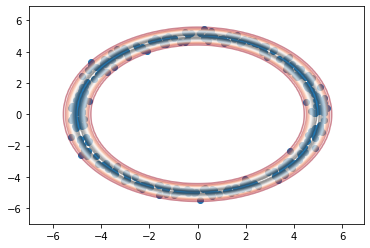

In [7]:
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(true_sample[:,0], true_sample[:,1]);

In [8]:
true_variance = np.cov(true_sample, rowvar = False)

In [9]:
Niter_ula = 13*Niter
Niter_mala = 4*Niter
Niter_fr = 5*Niter
Niter_smcula = 3*Niter
Niter_smcmala = 4*Niter

In [10]:
gamma_mala = 0.055
gamma_smcmala = 0.055

In [11]:
Nalgo = 6
Nrep = 50

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [12]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ystar, sigma, X0)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain[i,:], accepted_mala = algo.ParallelMALA(gamma_mala, Niter_mala, ystar, sigma, X0)
    end = time.time()
    runtime[i, 1] = end-start
    ## SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_FR(gamma, Niter_fr, ystar, sigma, X0, 1)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ystar, sigma, X0, nmcmc)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ystar, sigma, X0, nmcmc)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x[i,:], smcmala_w[i,:], accepted_smcmala = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, ystar, sigma, X0, 1)
    end = time.time()
    runtime[i, 5] = end-start

In [13]:
np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

0.5614966666666666

In [14]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.5634166666666666

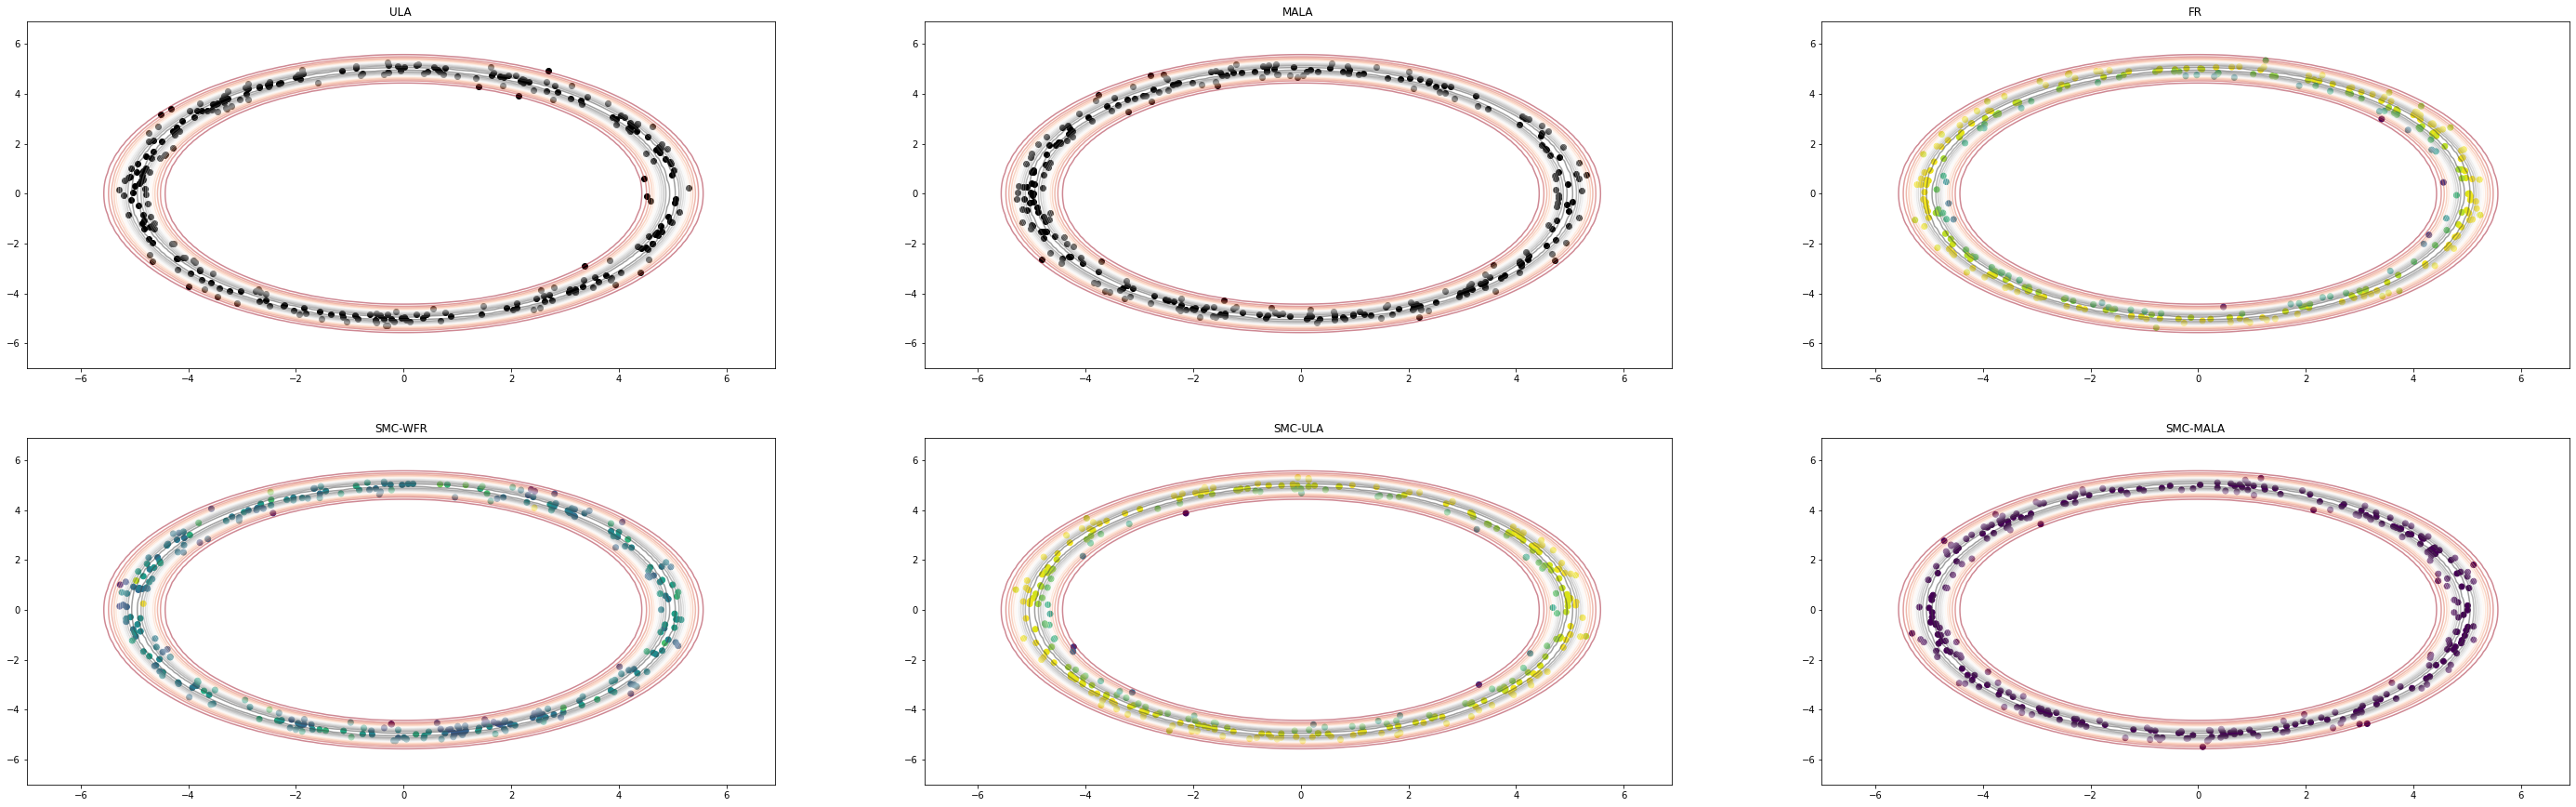

In [15]:
i = Nrep-1
plt.figure(figsize = (20,6))
plt.subplot(2, 3, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[i, -1, 0, :], ula_chain[i, -1, 1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(mala_chain[i, -1, 0, :], mala_chain[i, -1, 1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[i, -1, 0, :], fr_x[i, -1, 1, :], c = fr_w[i, -1, :]);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[i, -1, 0, :], wfr_x[i, -1, 1, :], c = wfr_w[i, -1, :]);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[i, -1, 0, :], smcula_x[i, -1, 1, :], c = smcula_w[i, -1, :]);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[i, -1, 0, :], smcmala_x[i, -1, 1, :], c = smcmala_w[i, -1, :]);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [16]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime

array([1.81432136, 1.91321157, 1.60983316, 1.5385482 , 1.74264596,
       1.93247019])

In [17]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [18]:
w1_ula = np.zeros((Nrep, d, Niter_ula))
w1_mala = np.zeros((Nrep, d, Niter_mala))
w1_fr = np.zeros((Nrep, d, Niter_fr))
w1_wfr = np.zeros((Nrep, d, Niter))
w1_smcula = np.zeros((Nrep, d, Niter_smcula))
w1_smcmala = np.zeros((Nrep, d, Niter_smcmala))

mmd_ula = np.zeros((Nrep, Niter_ula))
mmd_mala = np.zeros((Nrep, Niter_mala))
mmd_fr = np.zeros((Nrep, Niter_fr))
mmd_wfr = np.zeros((Nrep, Niter))
mmd_smcula = np.zeros((Nrep, Niter_smcula))
mmd_smcmala = np.zeros((Nrep, Niter_smcmala))

cov_ula = np.zeros((Nrep, Niter_ula))
cov_mala = np.zeros((Nrep, Niter_mala))
cov_fr = np.zeros((Nrep, Niter_fr))
cov_wfr = np.zeros((Nrep, Niter))
cov_smcula = np.zeros((Nrep, Niter_smcula))
cov_smcmala = np.zeros((Nrep, Niter_smcmala))

In [19]:
for j in range(Nrep):
    for i in range(Niter_ula):
        cov_ula[j, i] = np.mean((np.cov(ula_chain[j, i, :, :]) - true_variance)**2)
        for k in range(d):
            w1_ula[j, k, i]  = stats.wasserstein_distance(ula_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter_mala):
        cov_mala[j, i] = np.mean((np.cov(mala_chain[j, i, :, :]) - true_variance)**2)
        for k in range(d):
            w1_mala[j, k, i]  = stats.wasserstein_distance(mala_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter):
        cov_wfr[j, i] = np.mean((np.cov(wfr_x[j, i, :, :], aweights = wfr_w[j, i, :], bias = True) - true_variance)**2)
        for k in range(d):
            w1_wfr[j, k, i]  = stats.wasserstein_distance(wfr_x[j, i, k, :], true_sample[:, k], u_weights = wfr_w[j, i, :])
    for i in range(Niter_fr):
        cov_fr[j, i] = np.mean((np.cov(fr_x[j, i, :, :], aweights = fr_w[j, i, :], bias = True) - true_variance)**2)
        for k in range(d):
            w1_fr[j, k, i]  = stats.wasserstein_distance(fr_x[j, i, k, :], true_sample[:, k], u_weights = fr_w[j, i, :])
    for i in range(Niter_smcula):
        cov_smcula[j, i] = np.mean((np.cov(smcula_x[j, i, :, :], aweights = smcula_w[j, i, :], bias = True) - true_variance)**2)
        for k in range(d):
            w1_smcula[j, k, i]  = stats.wasserstein_distance(smcula_x[j, i, k, :], true_sample[:, k], u_weights = smcula_w[j, i, :])
    for i in range(Niter_smcmala):
        cov_smcmala[j, i] = np.mean((np.cov(smcmala_x[j, i, :, :], aweights = smcmala_w[j, i, :], bias = True) - true_variance)**2)
        for k in range(d):
            w1_smcmala[j, k, i]  = stats.wasserstein_distance(smcmala_x[j, i, k, :], true_sample[:, k], u_weights = smcmala_w[j, i, :])

In [20]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [21]:
w1_ula_plot = np.mean(np.mean(w1_ula, axis = 1), axis = 0)
w1_mala_plot = np.mean(np.mean(w1_mala, axis = 1), axis = 0)
w1_fr_plot = np.mean(np.mean(w1_fr, axis = 1), axis = 0)
w1_wfr_plot = np.mean(np.mean(w1_wfr, axis = 1), axis = 0)
w1_smcula_plot = np.mean(np.mean(w1_smcula, axis = 1), axis = 0)
w1_smcmala_plot = np.mean(np.mean(w1_smcmala, axis = 1), axis = 0)

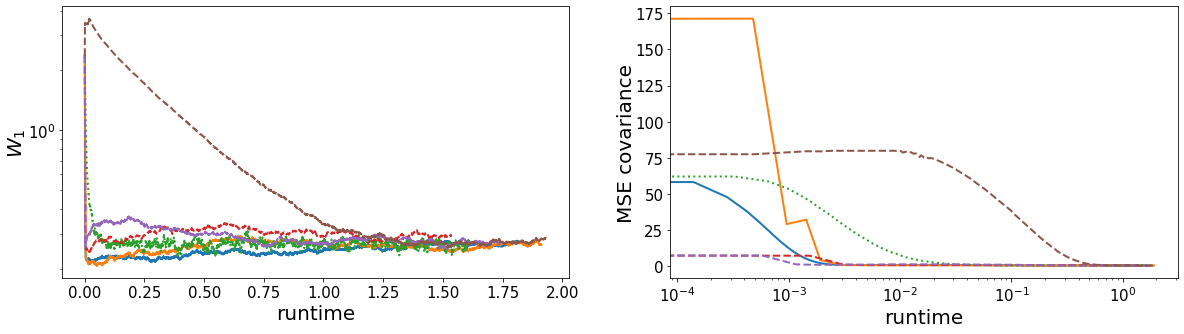

In [27]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.semilogy(xx_ula, w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(xx_mala, w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(xx_fr, w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.semilogx(xx_ula, np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(xx_mala, np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(xx_fr, np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.savefig('donut_runtime.pdf', bbox_inches="tight")

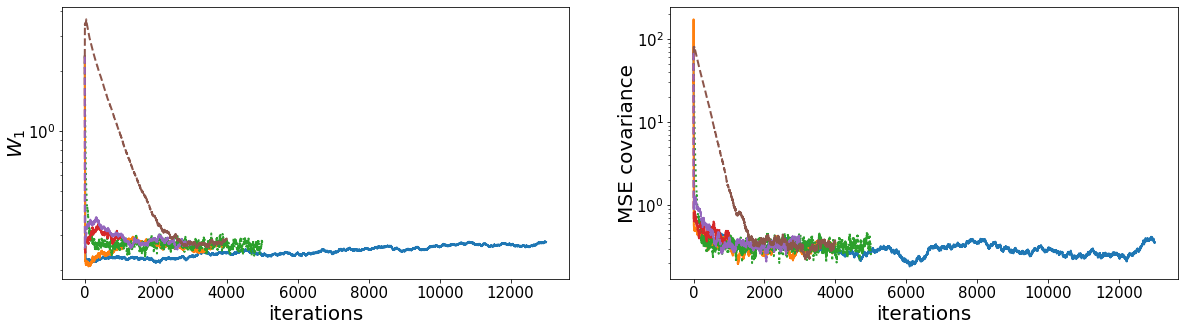

In [26]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.semilogy(w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.subplot(1, 2, 2)
plt.semilogy(np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.savefig('donut_iter.pdf', bbox_inches="tight")

In [52]:
np.mean(w1_ula, axis = 1).shape

(50, 13000)

In [40]:
import pandas as pd

In [63]:
df = pd.DataFrame(np.concatenate((cov_ula, np.mean(w1_ula, axis = 1), xx_ula[:, np.newaxis].T)));
df.to_csv("donut_ula.csv", index=False)

df = pd.DataFrame(np.concatenate((cov_mala, np.mean(w1_mala, axis = 1), xx_mala[:, np.newaxis].T)));
df.to_csv("donut_mala.csv", index=False)

df = pd.DataFrame(np.concatenate((cov_fr, np.mean(w1_fr, axis = 1), xx_fr[:, np.newaxis].T)));
df.to_csv("donut_fr.csv", index=False)

df = pd.DataFrame(np.concatenate((cov_wfr, np.mean(w1_wfr, axis = 1), xx_wfr[:, np.newaxis].T)));
df.to_csv("donut_wfr.csv", index=False)

df = pd.DataFrame(np.concatenate((cov_smcula, np.mean(w1_smcula, axis = 1), xx_smcula[:, np.newaxis].T)));
df.to_csv("donut_smcula.csv", index=False)

df = pd.DataFrame(np.concatenate((cov_smcmala, np.mean(w1_smcmala, axis = 1), xx_smcmala[:, np.newaxis].T)));
df.to_csv("donut_smcmala.csv", index=False)

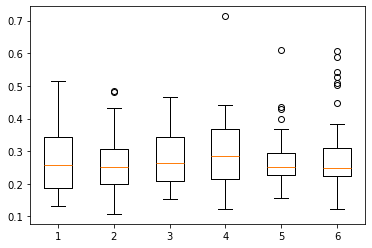

In [50]:
plt.boxplot([np.mean(w1_ula[:, :, -1], axis = 1), np.mean(w1_mala[:, :, -1], axis = 1), np.mean(w1_fr[:, :, -1], axis = 1), np.mean(w1_wfr[:, :, -1], axis = 1), np.mean(w1_smcula[:, :, -1], axis = 1), np.mean(w1_smcmala[:, :, -1], axis = 1)]);